In [12]:
#Version 18
# More cleanup, all settings are in one place
# still to fix - permissions to delete folders


In [13]:
#all imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import csv
import imageio
from datetime import datetime
import pwd
import grp
import shutil
import json

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras import backend as K
from keras.optimizers import SGD
from keras import regularizers


In [14]:
# SEED initialization
K.set_image_dim_ordering('th')
seed = 7
np.random.seed(seed)


In [15]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def readimagesfromfolder(path, color, show):
	imagepackage_list = []
	imagepackage = []
	imagelist = []
	filelist = sorted(os.listdir(path))
	for filename in filelist:
		fullfilename =  path + filename
		#print(fullfilename)        
		singleimage = imageio.imread(fullfilename)
		singleimage = cv2.resize(singleimage,(96,96), interpolation=cv2.INTER_AREA)        
		singleimage = rgb2gray(singleimage)
		#print(singleimage)        
		if show==1:
			plt.imshow(singleimage)
			plt.show()
		imagepackage.append(singleimage)
		imagepackage_list.append(imagepackage)        
		imagepackage = []        
	#print(len(imagepackage))        
	imagepackage_list = np.float32(imagepackage_list)
	#cv2.destroyAllWindows()
	return imagepackage_list

def readlabelfromcsv(filename):
    training_y = []
    with open(filename) as f:
        #training_y.append(f.readline())
        content = csv.reader(f)
        for line in content:
            #print(line[0])
            training_y.append(int(line[0]))
    return training_y


In [16]:


def load_data(mainfolder):
    folderpath = mainfolder+'training/'
    X_train=readimagesfromfolder(folderpath, 0, 0)
    y_train = readlabelfromcsv(mainfolder+'training.csv')

    folderpath = mainfolder+'test/'
    X_test=readimagesfromfolder(folderpath, 0, 0)
    y_test = readlabelfromcsv(mainfolder+'test.csv')
    
    X_train = X_train / 255
    X_test = X_test / 255
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]

    return X_train, y_train, X_test, y_test, num_classes


#datagen.fit(X_train) necessary only when using zca

In [17]:
def show_data_info(X_train,X_test,y_train,y_test):
    print(np.shape(X_train))
    print(np.shape(X_test))

    print(y_train)
    print(np.shape(y_train))

    print(y_test)
    print(np.shape(y_test))


In [18]:
#saving everything in one folder
def plot_accuracy(path, history):
    figure = plt.figure(figsize=(20,20))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("model accuracy")
    plt.grid(True)

    plt.legend(["train", "test"], loc="upper left")
    plt.show()
    figure.savefig(path+"/accuracy.png")
    
def save_experiment(history, generator_settings):
    
    # created folder based on current time
    start = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
    path = str(start)
    os.mkdir(path)
    
    #print history.history
    np.save(path + "/history", history.history)
    
    #save model scheme
    modelscheme = model.to_json()
    with open(path+"/modelscheme.json", "w+") as f:
        f.write(modelscheme)
        f.close()
    
    #create a plot with val accuracy    
    plot_accuracy(path, history)
    source = "modelcheckpoints"
    target = path
    shutil.move(source, target)
    
    #save generator settings
   
    with open(path+"/generator_settings.json","w+") as f:
        json.dump(generator_settings, f)
        f.close
    
    # trying to fix issues with permissions - still no luck
    uid = pwd.getpwnam("nobody").pw_uid
    gid = grp.getgrnam("nogroup").gr_gid
    os.chown(path, uid, gid)


    for dirpath, dirnames, filenames in os.walk('./'+path):
        for filename in filenames:
            path = os.path.join(dirpath, filename)
            os.chown(path, uid, gid) # for example
            os.chmod(path, 0o777)

def my_callbacks():
    if not(os.path.isdir("modelcheckpoints")):
        os.mkdir("modelcheckpoints")
    filename = "modelcheckpoints/model_epoch_{epoch:02d}_val_acc_{val_acc:.2f}.hd5"
    earlystopping = EarlyStopping(monitor = "val_acc", patience = 20, verbose=1, mode="auto")
    checkpoint = ModelCheckpoint(filename, monitor = "val_acc", verbose =1, mode="auto", save_best_only = "True")
    list_of_callbacks = [earlystopping, checkpoint]
    return list_of_callbacks

In [19]:
############################################ model and generator settings below ###############

In [20]:
generator_settings = {
    "featurewise_center": False,  
    "samplewise_center" : False,  
    "featurewise_std_normalization" : False, 
    "samplewise_std_normalization" : False,  
    "zca_whitening": False,  
    "rotation_range": 10,
    "zoom_range" : 0.2,
    "width_shift_range": 0.3,  # randomly shift images horizontally (fraction of total width)
    "height_shift_range" :0.3,  # randomly shift images vertically (fraction of total height)
    "horizontal_flip": True,  # randomly flip images
    "vertical_flip": False,
    "fill_mode":"constant", 
    "cval":0}

datagen = ImageDataGenerator(**generator_settings) #unpacking dictionary values - beautiful isn't it? 

In [21]:
def larger_model():
	# create model
	model = Sequential()
	model.add(Convolution2D(16, 3, 1, border_mode='same', input_shape=(1, 96, 96), activation='relu'))
	model.add(Convolution2D(24, 5, 3, border_mode='same', activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Convolution2D(32, 5, 3, border_mode='same', activation='relu'))
	model.add(Convolution2D(48, 5, 3, border_mode='same', activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(1000, activation='relu'))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 16, 96, 96)    64          convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 24, 96, 96)    5784        convolution2d_5[0][0]            
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 24, 48, 48)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 24, 48, 48)    0           maxpooling2d_3[0][0]             
___________________________________________________________________________________________

/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:1462: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_acc improved from -inf to 0.58333, saving model to modelcheckpoints/model_epoch_00_val_acc_0.58.hd5
52s - loss: 0.9819 - acc: 0.5146 - val_loss: 0.8005 - val_acc: 0.5833
Epoch 2/100
Epoch 00001: val_acc improved from 0.58333 to 0.75000, saving model to modelcheckpoints/model_epoch_01_val_acc_0.75.hd5
20s - loss: 0.6969 - acc: 0.7045 - val_loss: 0.5447 - val_acc: 0.7500
Epoch 3/100
Epoch 00002: val_acc improved from 0.75000 to 0.75000, saving model to modelcheckpoints/model_epoch_02_val_acc_0.75.hd5
20s - loss: 0.5205 - acc: 0.7915 - val_loss: 0.6611 - val_acc: 0.7500
Epoch 4/100
Epoch 00003: val_acc improved from 0.75000 to 0.77083, saving model to modelcheckpoints/model_epoch_03_val_acc_0.77.hd5
20s - loss: 0.4171 - acc: 0.8395 - val_loss: 0.4091 - val_acc: 0.7708
Epoch 5/100
Epoch 00004: val_acc improved from 0.77083 to 0.85417, saving model to modelcheckpoints/model_epoch_04_val_acc_0.85.hd5
20s - loss: 0.3072 - acc: 0.8873 - val_loss: 0.3369 - val_acc: 0.8542
Epoch

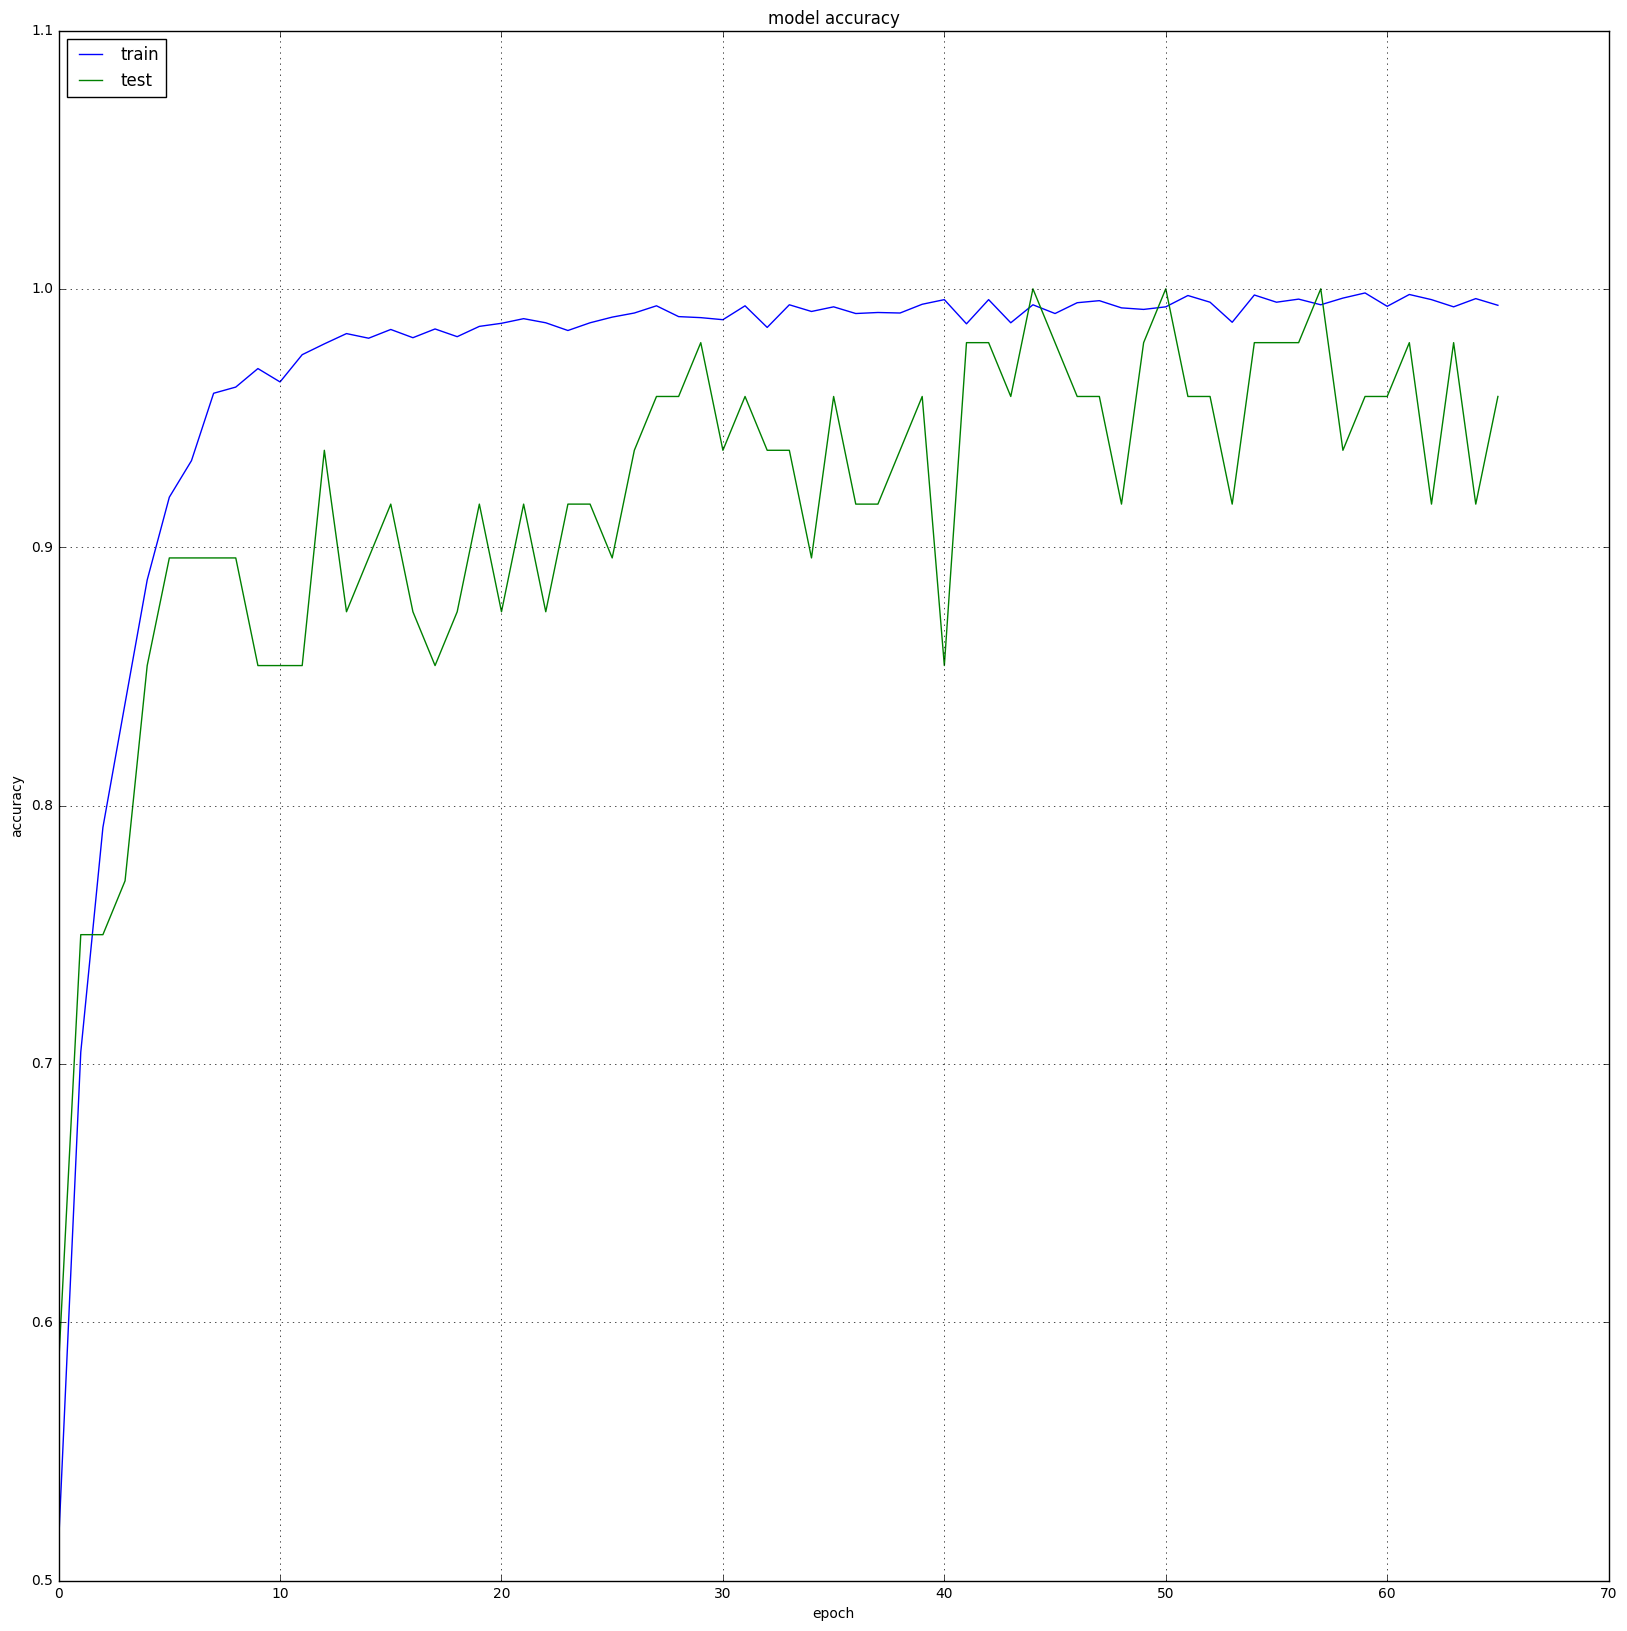

[0.06703479029238224, 0.95833333333333337]
Baseline Error: 4.17%


In [22]:
mainfolder = 'data/basic/'
X_train, y_train, X_test, y_test, num_classes = load_data(mainfolder)

# build the model
model = larger_model()
model.summary()

# Fit the model
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=25), callbacks = my_callbacks(), samples_per_epoch = 5000, nb_epoch = 100, verbose=2, validation_data=(X_test, y_test))

# save all information about current experiment
save_experiment(history, generator_settings)
    
scores = model.evaluate(X_test, y_test, verbose=0)
print scores
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

